# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import random
from prettytable import PrettyTable
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

# Define original train and test data (provided from Udacity)
training_file = 'train.p'
testing_file = 'test.p'

# Open original train and test data (provided from Udacity)
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Read in the training dataset (signs + labels)
X_train, y_train = train['features'], train['labels']
# Read in the training dataset (signs + labels)
X_test, y_test = test['features'], test['labels']
    
# Warning if there data and labels are not the same length
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# This function collects some information about the training set
# Class-IDs
# Number of signs per class (without additional, augmented data)
# Number of signs per class (with additional, augmented data)
# Signnames per class
# Number of signs in the smallest class
# Number of signs in the biggest class
def collect_information_training_set(data_set_labels):
    count_biggest_class = 0
    count_smallest_class = 100000000
    total_number_images_unmod = 0
    w, h = 4, 43 
    info_classes_in = [[0 for x in range(w)] for y in range(h)] 

    # Set the class IDs in the first column
    for i in range(0, len(info_classes_in)):
        info_classes_in[i][0] = i

    # Count the number of images per class and write it in the second and third column
    for i in range(len(data_set_labels)):
        count = int(data_set_labels[i])
        info_classes_in[int(count)][1] += 1
        info_classes_in[int(count)][2] += 1

    # Collect the signnames
    with open( 'signnames.csv', 'r' ) as image_names:
        reader = csv.reader(image_names)
        image_names = list(reader)
    
    image_names = image_names[1::] # Don't take the csv header
    
    # Find the class with the most/least images
    for i in range(0, len(info_classes_in)):
        # Highest number of images
        if info_classes_in[i][1] > count_biggest_class:
            count_biggest_class = info_classes_in[i][1]
        # Lowest number of images
        if info_classes_in[i][1] < count_smallest_class:
            count_smallest_class = info_classes_in[i][1]
        # Signnames
        info_classes_in[i][3] = image_names[i][1]
            
    return info_classes_in, count_biggest_class, count_smallest_class

# This function delivers the number of distinct classes (in training and test-data together)
def get_distinct_classes(training_labels, test_labels):
    # How many unique classes/labels there are in the dataset.
    distinctmyList = []
    a_list = []
    y_dataset = np.concatenate((training_labels, test_labels), axis=0)

    for i in y_dataset:
        a_list.append(i)
    distinctmyList.append(list(set(a_list)))
    n_classes = len(distinctmyList[0])
    return n_classes

# This function prints out some information about the datasets (training and testing)
def print_dataset_information(training_features, training_labels, test_features, test_labels):
    # Number of training examples
    n_train = len(training_features)

    # Number of testing examples.
    n_test = len(test_features)

    # What's the shape of an traffic sign image?
    image_shape = training_features[0].shape

    # Get the number of distinct classes
    n_classes = get_distinct_classes(training_labels, test_labels)

    print("Number of training images:")
    print("Value: ", n_train)
    print("\nNumber of testing images:")
    print("Value: ", n_test)
    print("\nImage data shape:")
    print("Value: ", image_shape)
    print("\nTotal number of classes:")
    print("Value: ", n_classes)
    
# This function prints more detailed information about the classes
# How many signs are available per class?
# Names of the signs per class
def print_class_information(info_classes_in):
    # Maximum images per class
    print("Maximum images per class: ", count_biggest_class)
    
    # Minimum images per class
    print("Minimum images per class: ", count_smallest_class)
    print()

    # Show information per class (each row is one class)
    list_show = []    
    for i in range(0, len(info_classes_in)):
        list_show.append(info_classes_in[i][1])
        
    # Get the number of distinct classes
    n_classes = get_distinct_classes(y_train, y_test)
    
    plt.bar(np.arange(n_classes), list_show , align='center', color='green')
    plt.xlabel('Class-ID')
    plt.ylabel('Number')
    plt.xlim([-1, 43])
    plt.title("Training set: Number of images per class")
    plt.show()
    
    # Print a table with Class-IDs and image-names
    class_discription = PrettyTable()
    class_discription.field_names = ['Class-ID', 'Description']
    class_discription.align['Description'] = "l"
    for i in range(len(info_classes_in)):
        class_discription.add_row([info_classes_in[i][0], info_classes_in[i][3]])

    print(class_discription)

print_dataset_information(X_train, y_train, X_test, y_test)

Number of training images:
Value:  39209

Number of testing images:
Value:  12630

Image data shape:
Value:  (32, 32, 3)

Total number of classes:
Value:  43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

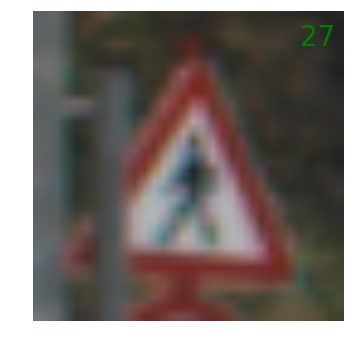

In [3]:
# This function prints out one single image (defined by its index) and adds the label
# Only for testing to get images of a certain class
def show_single_image(img_pack, label_pack, color):
    index = 30660
    image = img_pack[index].squeeze()
    plt.axis('off')
    if len(label_pack) > 0:
        plt.annotate(int(label_pack[index]), xy=(27, 3), color='green', fontsize='20')
    if color == 1:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray')
        
show_single_image(X_train, y_train, 1)

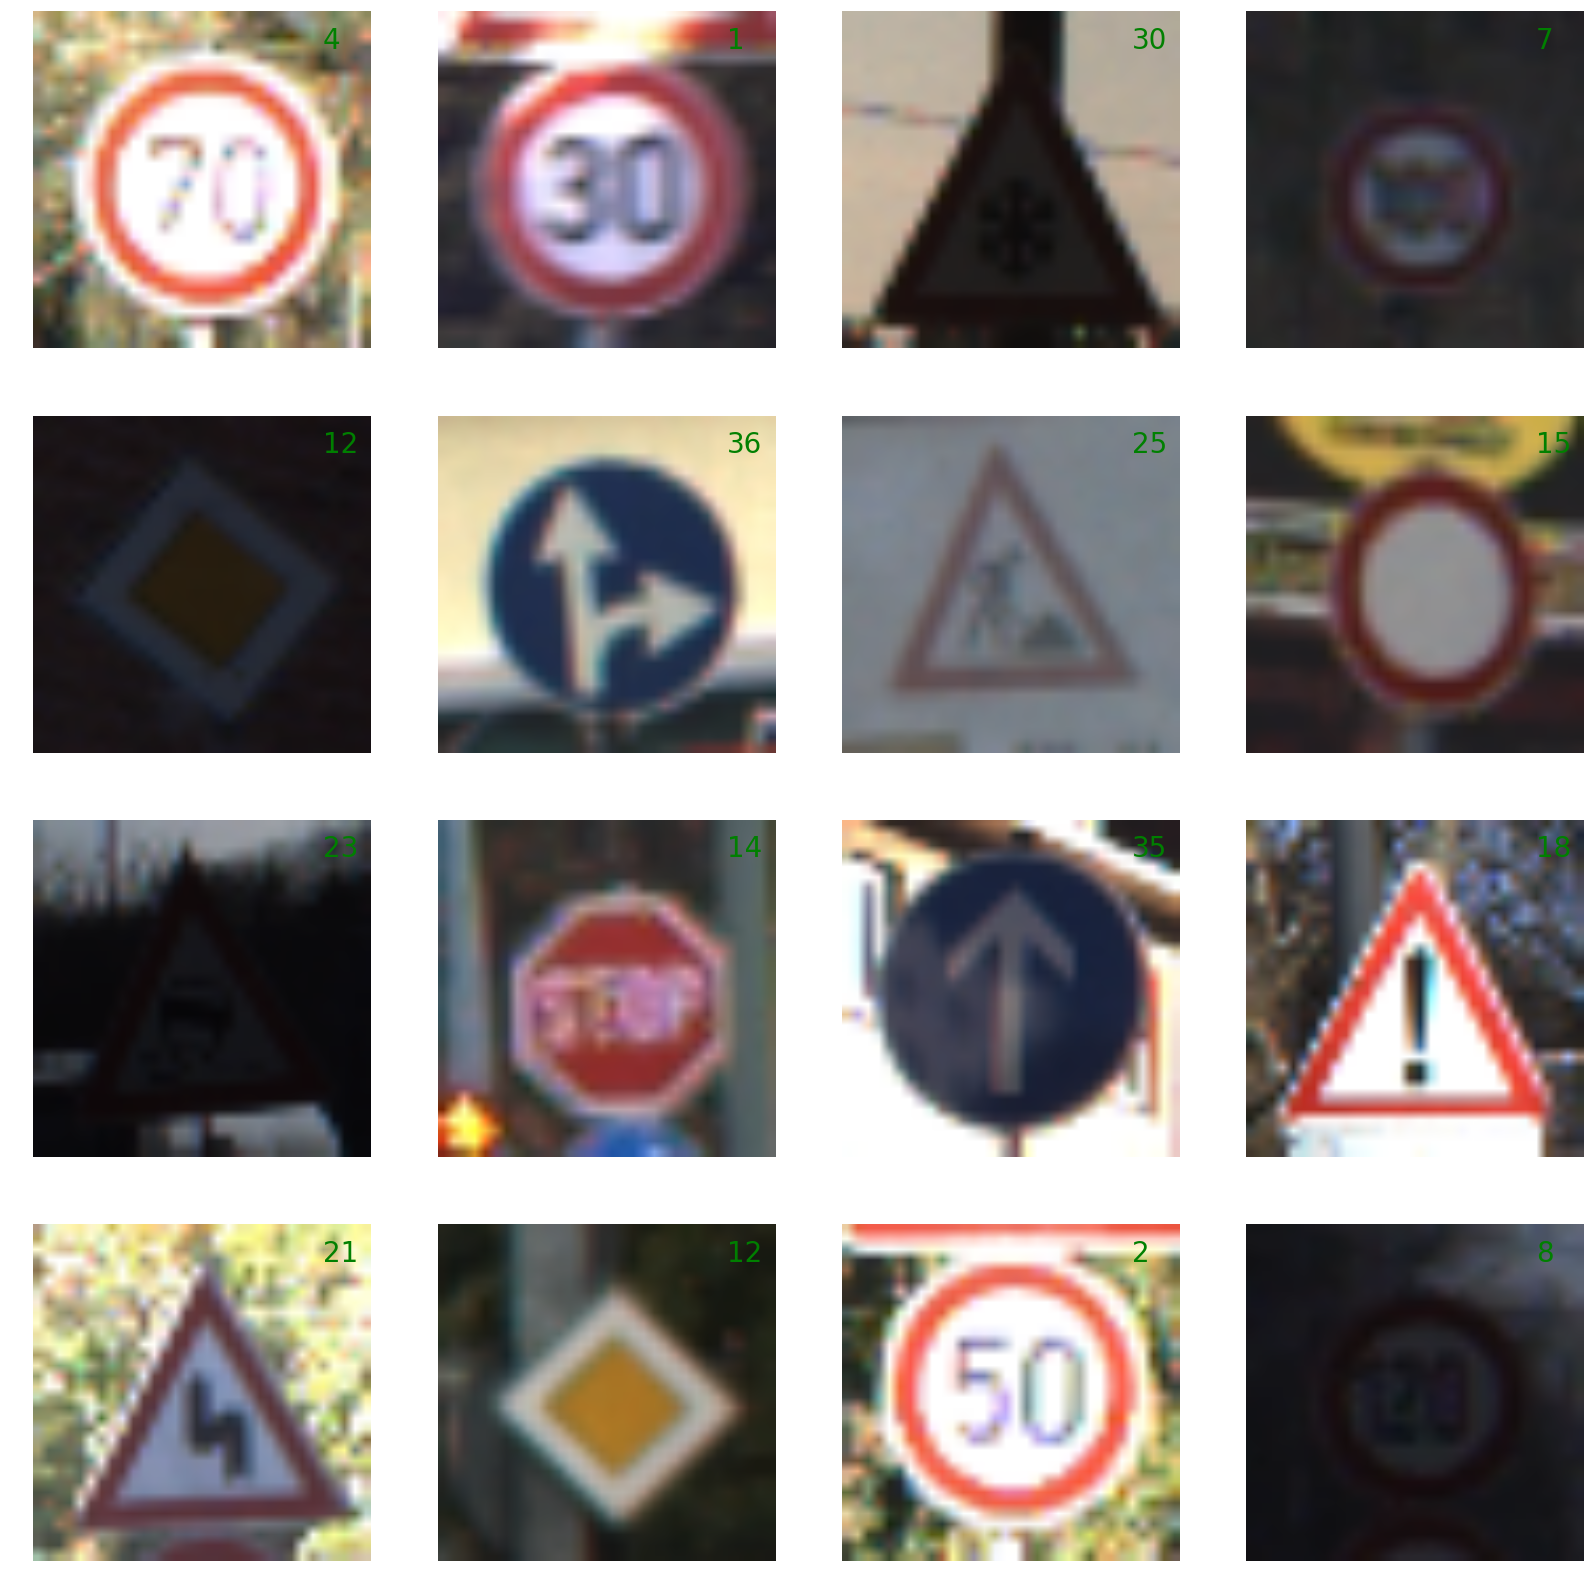

In [4]:
# Data exploration visualization

# This function prints out one random image of the defined image-pack and adds the label
def show_single_random_image(img_pack, label_pack, color):
    # print a random image of a img_pack and its label
    index = random.randint(0, len(img_pack)-1)
    image = img_pack[index].squeeze()
    plt.axis('off')
    if len(label_pack) > 0:
        plt.annotate(int(label_pack[index]), xy=(27, 3), color='green', fontsize='20')
    if color == 1:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray')

# This function prints random images of a img_pack and adds the labels
# The parameter number defines how many images should be printed
# The parameter choose_random defines if the images are taken randomly or every image from the beginning
def show_images_as_table(img_pack, label_pack, choose_random, number):
    index_list = []
    for i in range(0, number):
        # Choose (number) images randomly out of img_pack
        if choose_random == 1:
            index_list.append(random.randint(0, len(img_pack))-1)
        # Show the first (number) images which are included in img_pack
        else:
            index_list.append(i)
    
    # This is not generic at the moment. Only works for number = 16 or 8
    # Should be improved
    if number == 16:
        dummy, axis = plt.subplots( 4, 4, figsize=(20,20))
    else:
        dummy, axis = plt.subplots( 2, 4, figsize=(20,10))
    
    columns = 0
    rows = 0
    old_row = 0
    count = 0
    for x in index_list:
        image = img_pack[x]
        
        if columns == 3:
            rows += 1
        columns = count % 4
        count += 1
        
        axis[rows, columns].imshow(image)
            
        if len(label_pack) > 0:
            axis[rows, columns].annotate(int(label_pack[x]), xy=(27, 3), color='green', fontsize='20')
        
        axis[rows,columns].axis('off')
        
    plt.show()
           
# Print 16 random images of the training set and add the labels
show_images_as_table(X_train, y_train , 1, 16)

Total number of training images:  39209
Maximum images per class:  2250
Minimum images per class:  210



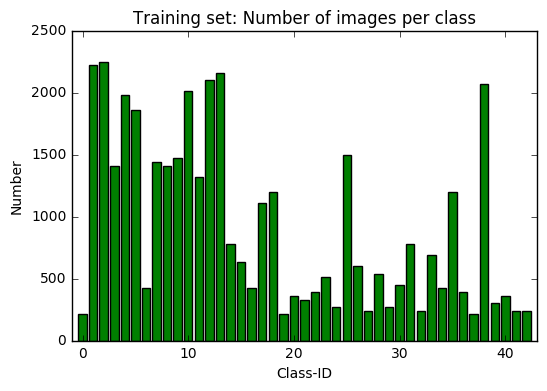

+----------+----------------------------------------------------+
| Class-ID | Description                                        |
+----------+----------------------------------------------------+
|    0     | Speed limit (20km/h)                               |
|    1     | Speed limit (30km/h)                               |
|    2     | Speed limit (50km/h)                               |
|    3     | Speed limit (60km/h)                               |
|    4     | Speed limit (70km/h)                               |
|    5     | Speed limit (80km/h)                               |
|    6     | End of speed limit (80km/h)                        |
|    7     | Speed limit (100km/h)                              |
|    8     | Speed limit (120km/h)                              |
|    9     | No passing                                         |
|    10    | No passing for vehicles over 3.5 metric tons       |
|    11    | Right-of-way at the next intersection              |
|    12   

In [5]:
# Collect some information about the training data (class-distribution)
info_classes, count_biggest_class, count_smallest_class = collect_information_training_set(y_train)

# Total number of images
total_number_images_mod = len(X_train)
print("Total number of training images: ", total_number_images_mod)

# Print some information about the training set
print_class_information(info_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

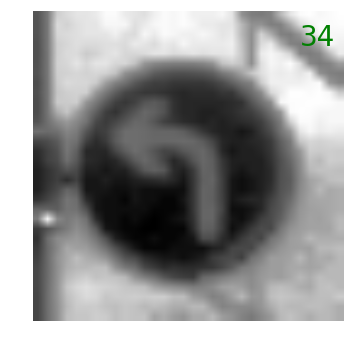

In [6]:
# Preprocess the data here

# This function does preprocessing on all the images, which are included in an array
# - Grayscaled all images
# - Histogram equalization
# - Normalize the values (between -1 to 1)
def preprocess_images(img_array):
    new_array = []
    for i in range(len(img_array)):
        # Change to grayscale
        image_mod_1 = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2GRAY)
        # Equalize the histogram
        image_mod_2 = cv2.equalizeHist(image_mod_1)
        # Normalize the values (-1 to 1)
        image_mod_3 = image_mod_2/127.5 - 1
        new_array.append(image_mod_3)
    new_array = np.array(new_array).reshape((-1,32,32,1))
    return new_array

# Preprocess the training data
X_train = preprocess_images(X_train)

# Preprocess the test data
X_test = preprocess_images(X_test)
    
# Show random image of the training data after preprocessing
show_single_random_image(X_train, y_train, 0)

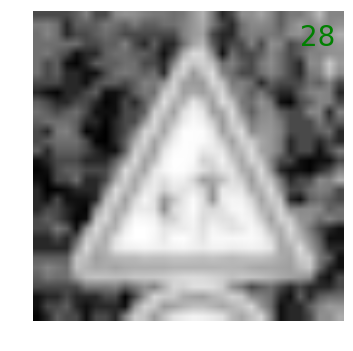

In [7]:
# Show random image of the test data after preprocessing
show_single_random_image(X_test, y_test, 0)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

The following preprocessing has been done on the dataset:
- Grayscaled all images
- Histogram equalization
- Normalize the values (between -1 to 1)


I have tested my network with RGB images and grayscaled ones. Usage of grayscaled ones showed much better results.
Histogram equalization usually increases the contrast of images. Normalisation of images doesn't change the content of the images, but it makes it much easier for the optimization to proceed numerical and the variables should always have zero mean, if possible.

Testimage which is not transformed but already preprocessed.
The testimage is randomly taken.
Shape: (32, 32)


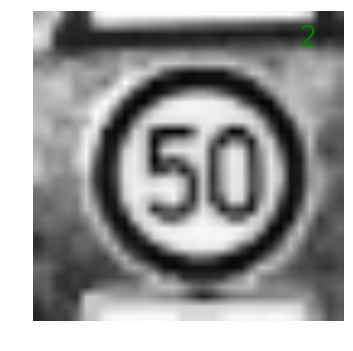

In [8]:
# Generate additional, augmented data
# More than one cell is used
        
# This function gets an image as input and generates a slightly modified one
# - Rotate the image randomly
# - Translate the image randomly
# - Shear the image randomly
def modify_image(image):
    # Rotate the images a little bit (random value)
    rotate_by = np.random.uniform(12) - 6 # +/- 6 degree    
    rotate_matrix = cv2.getRotationMatrix2D((32/2,32/2),rotate_by,1)

    # Translate image a little bit (random value)
    trans_X = 3 * np.random.uniform() - 2
    trans_Y = 3 * np.random.uniform() - 2
    trans_matrix = np.float32([[1,0,trans_X],[0,1,trans_Y]])

    # Shear image a little bit (random value)
    shear_in1 = np.float32([[5,5],[20,5],[5,20]])
    shear1 = 1 + 6 * np.random.uniform()
    shear2 = 16 + 6 * np.random.uniform()
    shear_in2 = np.float32([[shear1,5],[shear2,shear1],[5,shear2]])
    shear_matrix = cv2.getAffineTransform(shear_in1,shear_in2)
        
    image = cv2.warpAffine(image,rotate_matrix,(32,32))
    image = cv2.warpAffine(image,trans_matrix,(32,32))
    image = cv2.warpAffine(image,shear_matrix,(32,32))
    
    return image

# This function delivers a randomly choosen image out of an image-pack and its label
def get_random_image(img_pack, label_pack):
    index = random.randint(0, len(img_pack)-1)
    image = img_pack[index].squeeze() 
    classid = label_pack[index]
    return image, classid
        
# For presentation, show one image before transforming and afterwards
image_to_transform, classid = get_random_image(X_train, y_train)
image_to_transform_shape = image_to_transform.shape
print('Testimage which is not transformed but already preprocessed.')
print('The testimage is randomly taken.')
print('Shape: ' + str(image_to_transform_shape))
plt.axis('off')
plt.annotate(int(classid), xy=(27, 3), color='green', fontsize='20')
plt.imshow(image_to_transform, cmap='gray')

Testimage which is preprocessed AND transformed.
The testimage is the same as the one above (to make comparison possible)
Shape: (32, 32, 1)


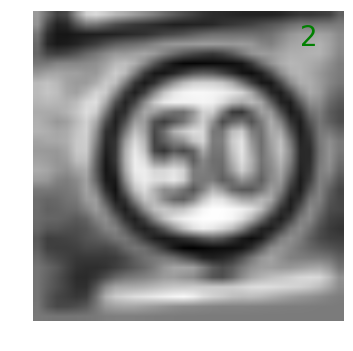

In [9]:
# For presentation, show one image before transforming and afterwards
image_to_transform = image_to_transform.reshape((32,32,1))
image_to_transform_shape = image_to_transform.shape
print('Testimage which is preprocessed AND transformed.')
print('The testimage is the same as the one above (to make comparison possible)')
print('Shape: ' + str(image_to_transform_shape))
image_to_transform = modify_image(image_to_transform)
plt.axis('off')
plt.annotate(int(classid), xy=(27, 3), color='green', fontsize='20')
plt.imshow(image_to_transform, cmap='gray')

In [10]:
# Generate / Load more data (augmented data)
# IMPORTANT: 
# In this cell, additional data can be added to X_train and y_train
# or
# an already available *.p with stored additional data (generated with the following code) can be loaded
# This is done because generating data takes a lot of time
# or
# the original training data (from Udacity) can be used

# Set the configuration variable to decide what to do
# generate_additional_data = 1 --> new data is generated and added to X_train and y_train
# load_additional_data = 1 AND generate_additional_data != 1 --> data is loaded from *.p and filled into X_train and y_train
# generate_additional_data = 0 AND load_additional_data = 0 --> the original training data (from Udacity) is used
# generate_additional_data = 1 AND load_additional_data = 1 --> new data is generated and added to X_train and y_train

generate_additional_data = 1
load_additional_data = 0
filename_to_store_load = 'train_final.p'

# Generate new data
if generate_additional_data == 1: 
    images_sum = 0
    # Counts to print a is-alive message in the notebook while generating additional data
    count1 = 0
    count2 = 0

    # ONLY for testing:
    # DEFAULT: Set to 1 if you really want to generate extra data (images+labels) ---> needs much time
    # Set to 0 if only for testing
    really_generate_images = 1
    really_generate_labels = 1

    # Collect some information about the original training set (from Udacity)
    info_classes, count_biggest_class, count_smallest_class = collect_information_training_set(y_train)
    
    # Define the number of images which every class should have (TODO edit for final solution)
    min_images_per_class = count_biggest_class
    #min_images_per_class = 1000
    
    print(X_train.shape)
    print(y_train.shape)
    for x in range(0, len(X_train)):
        #print('ClassID: ' + str(y_train[x]))
        images_per_class = info_classes[int(y_train[x])][1]
        #print('Images per Class: ' + str(images_per_class))
        images_to_generate = int(round(((min_images_per_class - images_per_class) / images_per_class),0))
        if images_to_generate == 0:
            if info_classes[int(y_train[x])][2] < min_images_per_class:
                images_to_generate = 1
        if info_classes[int(y_train[x])][2] >= min_images_per_class:
            images_to_generate = 0
        #print('Images to generate: ' + str(images_to_generate))
        images_sum = images_sum + images_to_generate
        for i in range(0, images_to_generate):
            # Count to print progress-data
            count2 += 1
            if count2 > 100:
                count2 = 0
                count1 += 1
                printcount = count1 * 100
                print('Generated images so far: ' + str(printcount))
            if really_generate_images == 1:
                # Generate the new image and add to X_train
                new_array = []
                image_in = X_train[x]
                image_out = modify_image(image_in)
                new_array.append(image_out)
                new_array = np.array(new_array).reshape((-1,32,32,1))
                X_train = np.vstack((X_train, new_array))
            if really_generate_labels == 1:
                # Generate the new label and add to y_train
                new_class = y_train[x]
                y_extra = np.zeros( 1 )
                y_extra[0] = int(np.ones( ( 1, ) ) * new_class)
                y_train = np.concatenate( (y_train, y_extra), axis=0 )
            info_classes[int(y_train[x])][2] += 1

    print('Images and labels generated total: ' + str(images_sum)) 
    print(X_train.shape)
    print(y_train.shape)
    
    # Store new X_train and y_train in a pickle file
    pickle.dump({
            "features" : X_train,
            "labels" : y_train
        }, open(filename_to_store_load, "wb" ) )
    
    print()
    print('Data stored to: ' + str(filename_to_store_load))

# load_additional_data = 0 AND generate_additional_data != 1--> Load data from *.p
elif load_additional_data == 1 and generate_additional_data != 1: 
    with open(filename_to_store_load, mode='rb') as f:
        train = pickle.load(f)

    X_train, y_train = train['features'], train['labels']

    assert(len(X_train) == len(y_train))
    print()
    print('Data loaded from: ' + filename_to_store_load)
# generate_additional_data = 0 AND load_additional_data = 0 --> the original training data (from Udacity) is used
else:
    print("The original training data (from Udacity) is used")


Data loaded from: train_extended_4.p


In [11]:
# Print some information about the training data
# If generate_additional_data OR load_additional_data has been choosen above this is already a training set
# with additional, augmented data
print_dataset_information(X_train, y_train, X_test, y_test)

Number of training images:
Value:  53870

Number of testing images:
Value:  12630

Image data shape:
Value:  (32, 32, 1)

Total number of classes:
Value:  43


Total number of training images:  53870
Maximum images per class:  2250
Minimum images per class:  840



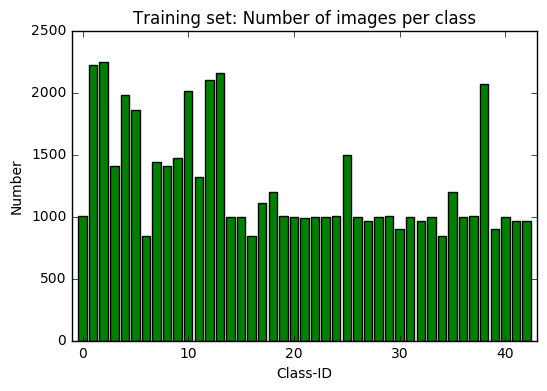

+----------+----------------------------------------------------+
| Class-ID | Description                                        |
+----------+----------------------------------------------------+
|    0     | Speed limit (20km/h)                               |
|    1     | Speed limit (30km/h)                               |
|    2     | Speed limit (50km/h)                               |
|    3     | Speed limit (60km/h)                               |
|    4     | Speed limit (70km/h)                               |
|    5     | Speed limit (80km/h)                               |
|    6     | End of speed limit (80km/h)                        |
|    7     | Speed limit (100km/h)                              |
|    8     | Speed limit (120km/h)                              |
|    9     | No passing                                         |
|    10    | No passing for vehicles over 3.5 metric tons       |
|    11    | Right-of-way at the next intersection              |
|    12   

In [12]:
# Collect some information about the training data (class-distribution)
info_classes, count_biggest_class, count_smallest_class = collect_information_training_set(y_train)

# Total number of images
total_number_images_mod = len(X_train)
print("Total number of training images: ", total_number_images_mod)

# Print some information about the training set
# If generate_additional_data OR load_additional_data has been choosen above this is already a training set
# with additional, augmented data
print_class_information(info_classes)

In [13]:
# Split the data into training/validation/testing sets here.

# Split up the training data to get validation data
# A fixed random_state has been choosen to make results compareable
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Warning if there data and labels are not the same length
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_validation)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the whole dataset.
distinctmyList =[]
a_list=[]
y_dataset = np.concatenate((y_train, y_test, y_validation), axis=0)

for i in y_dataset:
    a_list.append(i)
distinctmyList.append(list(set(a_list)))
n_classes = len(distinctmyList[0])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 43096
Number of validation examples = 10774
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Additional data has been generated for training and validation, but not for testing.
The reason is, that I wanted to increase the amount of data in the dataset, because after using dropouts the number of available images was rather small. As shown above there is a significant difference in the number of images per class in the original training set, provided by Udacity. When training is done on such a dataset the network gets biased to the classes, which have the highest number of images. This can be useful if this non-equal distribution is available in the real world and we want to respect this. But in this project, with a perhaps other distribution in the dataset for testing (or in real-world), the training-dataset should have nearly the same number of images in all classes, because we don't want to have the neuronal network biased to single classes of data. I decided to find out the highest number of images per class. For all classes with a lower number of images additional, augmented data has been generated. This was done by calculating how many images per class have to be added. For each existing image of the class the same number of new images was added. To do this, affine transformations have been applied to the single images (rotated, translated, sheared). The slightly transformation makes the data more real, because in real world not all traffic signs a fully visable, are not standing straight or things like this.

IMPORTANT: Configuration can be done to choose if the original training set (from Udacity) is used, augmented data is  generated within the running programm, which takes some time, or it data can be loaded out of a ready-made *.p-file. The *.p file was generated with the same algorithm as the one which is used when creating data directly in the running programm.

The training-set is splitted up in a training set and a validation set. This is done after generating additional, augmented data (if it is decided to add data). The split up is done the following way.

- 80% of the images are used for training
- 20% of the images are used for validation

The provided data set for testing was not affected, in the sense of a change in composition or scope. Only the mentioned preprocessing (grayscale, histogram equalization and normalization) of the values has been done too.

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)

EPOCHS = 40
BATCH_SIZE = 128

# This function defines the neuronal network itself
# Most of the net was taken from LeNet-5
def gadaNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name='weights_conv1')
    conv1_b = tf.Variable(tf.zeros(6), name='bias_conv1')
    conv1_op   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name='op_conv1') + conv1_b

    # Activation.
    conv1_act = tf.nn.relu(conv1_op, name='act_conv1')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_pool = tf.nn.max_pool(conv1_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='max_pool_conv1')
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='weights_conv2')
    conv2_b = tf.Variable(tf.zeros(16), name='bias_conv2')
    conv2_op   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID', name='op_conv2') + conv2_b
    
    # Activation.
    conv2_act = tf.nn.relu(conv2_op, name='act_conv2')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_pool = tf.nn.max_pool(conv2_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='max_pool_conv2')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2_pool)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='weights_fc1')
    fc1_b = tf.Variable(tf.zeros(120), name='bias_fc1')
    fc1_op   = tf.matmul(fc0, fc1_W, name='op_fc1') + fc1_b
    
    # Activation.
    fc1_act    = tf.nn.relu(fc1_op, name='act_fc1')
    
    # Dropout.
    fc1_drop = tf.nn.dropout(fc1_act, keep_prob, name='fc1_drop')

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='weights_fc2')
    fc2_b  = tf.Variable(tf.zeros(84), name='bias_fc2')
    fc2_op    = tf.matmul(fc1_drop, fc2_W, name='op_fc2') + fc2_b
    
    # Activation.
    fc2_act    = tf.nn.relu(fc2_op, name='act_fc2')

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='weights_fc3')
    fc3_b  = tf.Variable(tf.zeros(43), name='bias_fc3')
    logits = tf.matmul(fc2_act, fc3_W, name='op_fc3') + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Most of the architecture is similar to LeNet-5, because this performs significant better than own experiments.
The model is built up the following way:

- **Layer 1:**
    - Conv-Layer:
        - Input: 32x32x1 -> Grayscaled images with size 32x32
        - Output: 28x28x6
    - Activation:
        - Relu
    - Max Pooling -> filter_size = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID'
        - Input: 28x28x6
        - Output: 14x14x6   
- **Layer 2:**
    - Conv-Layer:
        - Input: 14x14x6
        - Output: 10x10x16
    - Activation:
        - Relu
    - Max Pooling -> filter_size = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID'
        - Input: 10x10x16
        - Output: 5x5x16
- **Flatten:**
    - For using fully connected layers aferwards
        - Input: 5x5x16
        - Output: 400
- **Layer 3:**
    - Fully-Connected-Layer:
        - Input: 400
        - Output: 120
    - Activation:
        - Relu
    - Dropout to prevent overfitting to the training data
        - Drop_keep = 0.5 when training
        - Drop_keep = 1.0 when training
- **Layer 4:**
    - Fully-Connected-Layer:
        - Input: 120
        - Output: 84
    - Activation:
        - Relu
- **Layer 5  -> this is the output layer which is mapped to the 43 classes in the dataset:**
    - Fully-Connected-Layer:
        - Input: 84
        - Output: 43
- **-----> Output**

To prevent overfitting of the model I decided to use dropouts. I had the best results when I only used one dropout after the first fully connected layer.

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Grayscaled images in size 32x32 are used as data for the model
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder( tf.float32, name='keep_prob')
one_hot_y = tf.one_hot(y, 43)

# Training pipeline
rate = 0.001

logits = gadaNet(x, keep_prob)
softmax_operation = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Evaluate Accuracy
def evaluate_accuracy_loss(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x) )
    return [total_accuracy / num_examples, total_loss/num_examples]

In [16]:
# Train the model
saver = tf.train.Saver()

# Run the training session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy, validation_loss = evaluate_accuracy_loss(X_validation, y_validation)
        
        # Print out the data for each epoch
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    # Save the trained model
    saver.save(sess, 'gadaNet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.687
Validation Loss = 1.100

EPOCH 2 ...
Validation Accuracy = 0.785
Validation Loss = 0.707

EPOCH 3 ...
Validation Accuracy = 0.850
Validation Loss = 0.525

EPOCH 4 ...
Validation Accuracy = 0.877
Validation Loss = 0.424

EPOCH 5 ...
Validation Accuracy = 0.897
Validation Loss = 0.359

EPOCH 6 ...
Validation Accuracy = 0.903
Validation Loss = 0.326

EPOCH 7 ...
Validation Accuracy = 0.916
Validation Loss = 0.280

EPOCH 8 ...
Validation Accuracy = 0.924
Validation Loss = 0.260

EPOCH 9 ...
Validation Accuracy = 0.928
Validation Loss = 0.243

EPOCH 10 ...
Validation Accuracy = 0.932
Validation Loss = 0.227

EPOCH 11 ...
Validation Accuracy = 0.937
Validation Loss = 0.212

EPOCH 12 ...
Validation Accuracy = 0.942
Validation Loss = 0.195

EPOCH 13 ...
Validation Accuracy = 0.945
Validation Loss = 0.183

EPOCH 14 ...
Validation Accuracy = 0.944
Validation Loss = 0.185

EPOCH 15 ...
Validation Accuracy = 0.951
Validation Loss = 0.165

EPOCH 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

As explained for question 5 I did take most of the things of a Standard-LeNet-5-Architecture.
Most of the parameters are not changed. I tried different changes but my accurancy and loss didn't get significant better.
- Optimizer: AdamOptimizer
- Batch Size: 128
- Epocs: 40 -> Experimented with different values -> tried early stopping
- Learing rate: 0.001
- Dropout rate in training: 0.5
- mu: 0
- sigma: 0.1

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

First I wanted to start from scratch with an own model, but this was not very succesful. I only could reach accurancys around 80%. So I gave LeNet-5 a try, as mentioned in the tutorial. This approach had significant better results from the beginning. So I decided to try a few changes on the LeNet-5 architecture. I added additional layers (conv and fully-connected) but this doesn't really made my results better, but training took longer, so I came back to the original architecture. To prevent overfitting of the model I decided to use dropouts. I tried this in different ways. First I used dropouts after each layer (conv and fully connected layers) this was not useful at all. At least I had to less training data. After this I tried dropouts for each fully connected layer, but in the end I had the best results when I only used one dropout after the first fully connected layer.

Sometimes I was really unsatisfied because my own models were much worse then LeNet-5. But in the end I took LeNet-5 as a starting point and tried a few things to play around. This way, I learned a lot and will give my own models a try in the future. But anyway lots of people with more experience in this area have worked on LeNet-5.

My conclusio is that having a good starting point makes life much easier but getting get final % is the hardest job.
In this project with its unequel class-distribution the adding of data is essential.

In [17]:
# Test the model with test-data
# Shuffle the test-set
X_test, y_test = shuffle(X_test, y_test)

# Run the test-session
with tf.Session() as sess:
    load_modul = tf.train.import_meta_graph('gadaNet.meta')
    load_modul.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy, test_loss = evaluate_accuracy_loss(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))
    print()

Test Accuracy = 0.943
Test Loss = 0.272



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Extra dataset size: (8, 32, 32, 3) | Datatype: uint8


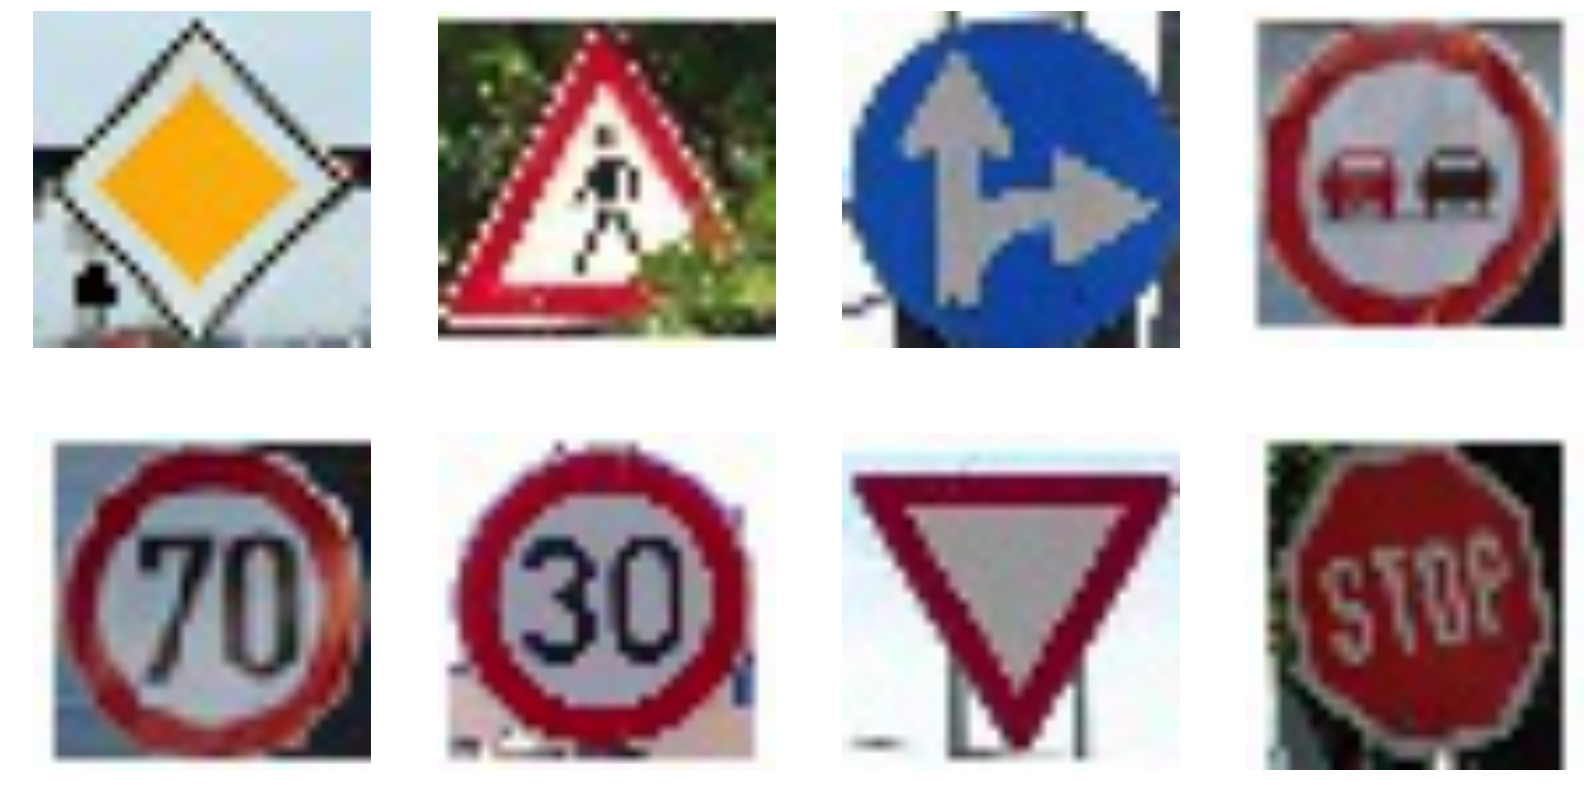

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os

def get_sign_files(dir):
    list_with_files = []
    for i in os.listdir(dir):
        if i.endswith(".jpg"):
            list_with_files.append(i)
    
    X_own_test_signs = np.zeros((len(list_with_files), 32, 32, 3), dtype='uint8')
    
    for x, file in enumerate(list_with_files):
        # Images opened with cv2 are in BGR format
        image = cv2.imread(dir +'/'+ file) 
        # If the pictures are not 32 x 32 than resize them
        image = cv2.resize(image,(32,32))
        # Convert from BGR to RGB
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
        X_own_test_signs[x] = image
            
    return X_own_test_signs, list_with_files

X_own_test_signs, list_with_files = get_sign_files('own_test_signs')

print('Extra dataset size: {} | Datatype: {}'.format(X_own_test_signs.shape, X_own_test_signs.dtype))

# Prints the 8 own traffic signs
show_images_as_table(X_own_test_signs, '', 0, 8)

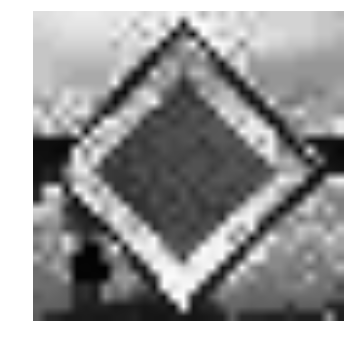

In [19]:
# Preprocess own test signs
X_own_test_signs_preproc = preprocess_images(X_own_test_signs)
    
# Shows random image of training data after preprocessing
show_single_random_image(X_own_test_signs_preproc, '', 0)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I take all my 8 own test images to test the model. 
- The "pedestrian sign" is a little bit hidden behind a tree, perhaps difficult
- The "stop sign" isn't mounted straight
- The "no passing sign" has a shadow on it which as the same direction as "end of no passing"
- The others should be easy from my point of view

Class-ID:  12
Sign name:  Priority road


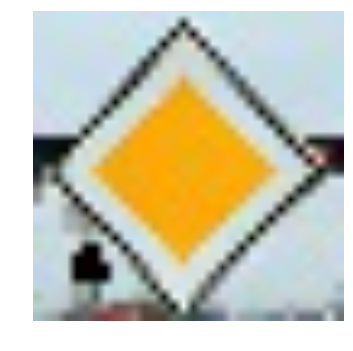

In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    load_modul = tf.train.import_meta_graph('gadaNet.meta')
    load_modul.restore(sess, tf.train.latest_checkpoint('./'))
    prediction_p = sess.run(softmax_operation, feed_dict={x: X_own_test_signs_preproc, keep_prob: 1})
    predictions = np.argmax(prediction_p, 1)
    # 5 highest probabilities
    five_top_k = tf.nn.top_k(softmax_operation, 5)
    five_top_k_probabilities = sess.run([ softmax_operation, five_top_k], feed_dict={x: X_own_test_signs_preproc, keep_prob: 1})
### Feel free to use as many code cells as needed.

def show_test_sign_with_predictions(idx):
    class_id = predictions[idx]
    print('Class-ID: ', class_id)
    sign_name = info_classes[class_id][3]
    print('Sign name: ', sign_name)
    image = X_own_test_signs[idx].squeeze() 
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
show_test_sign_with_predictions(0)

Class-ID:  27
Sign name:  Pedestrians


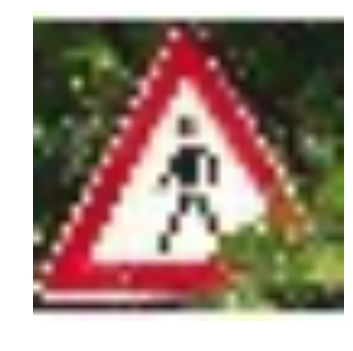

In [21]:
show_test_sign_with_predictions(1)

Class-ID:  36
Sign name:  Go straight or right


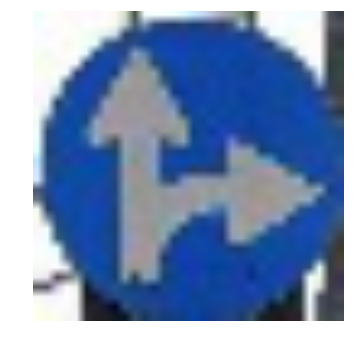

In [22]:
show_test_sign_with_predictions(2)

Class-ID:  9
Sign name:  No passing


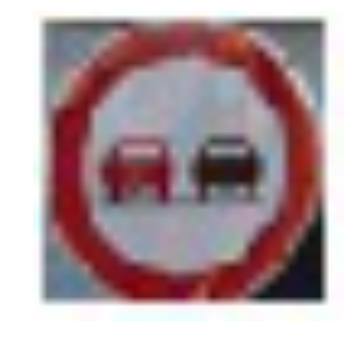

In [23]:
show_test_sign_with_predictions(3)

Class-ID:  4
Sign name:  Speed limit (70km/h)


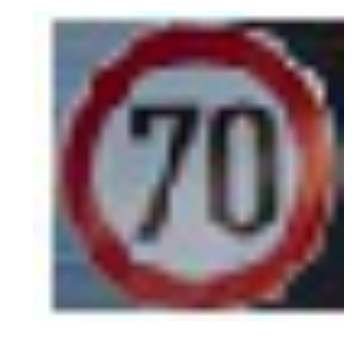

In [24]:
show_test_sign_with_predictions(4)

Class-ID:  1
Sign name:  Speed limit (30km/h)


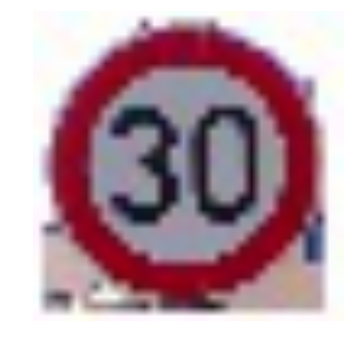

In [25]:
show_test_sign_with_predictions(5)

Class-ID:  13
Sign name:  Yield


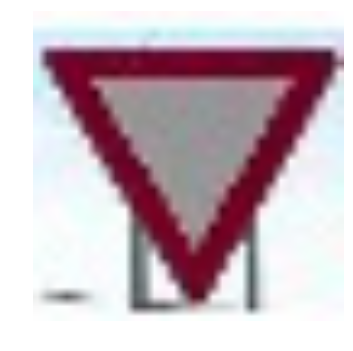

In [26]:
show_test_sign_with_predictions(6)

Class-ID:  14
Sign name:  Stop


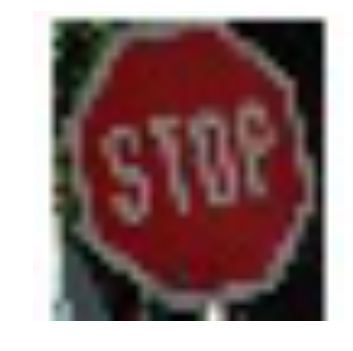

In [27]:
show_test_sign_with_predictions(7)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The following 8 own traffic signs have been used for testing.

- Priority road
    - Correct: Yes
- Pedestrians
    - Correct: Yes
- Go straight or right
    - Correct: No
- No passing
    - Correct: No
- Speed limit (70km/h)
    - Correct: No
- Speed limit (30km/h)
    - Correct: Yes
- Yield
    - Correct: Yes
- Stop
    - Correct: Yes

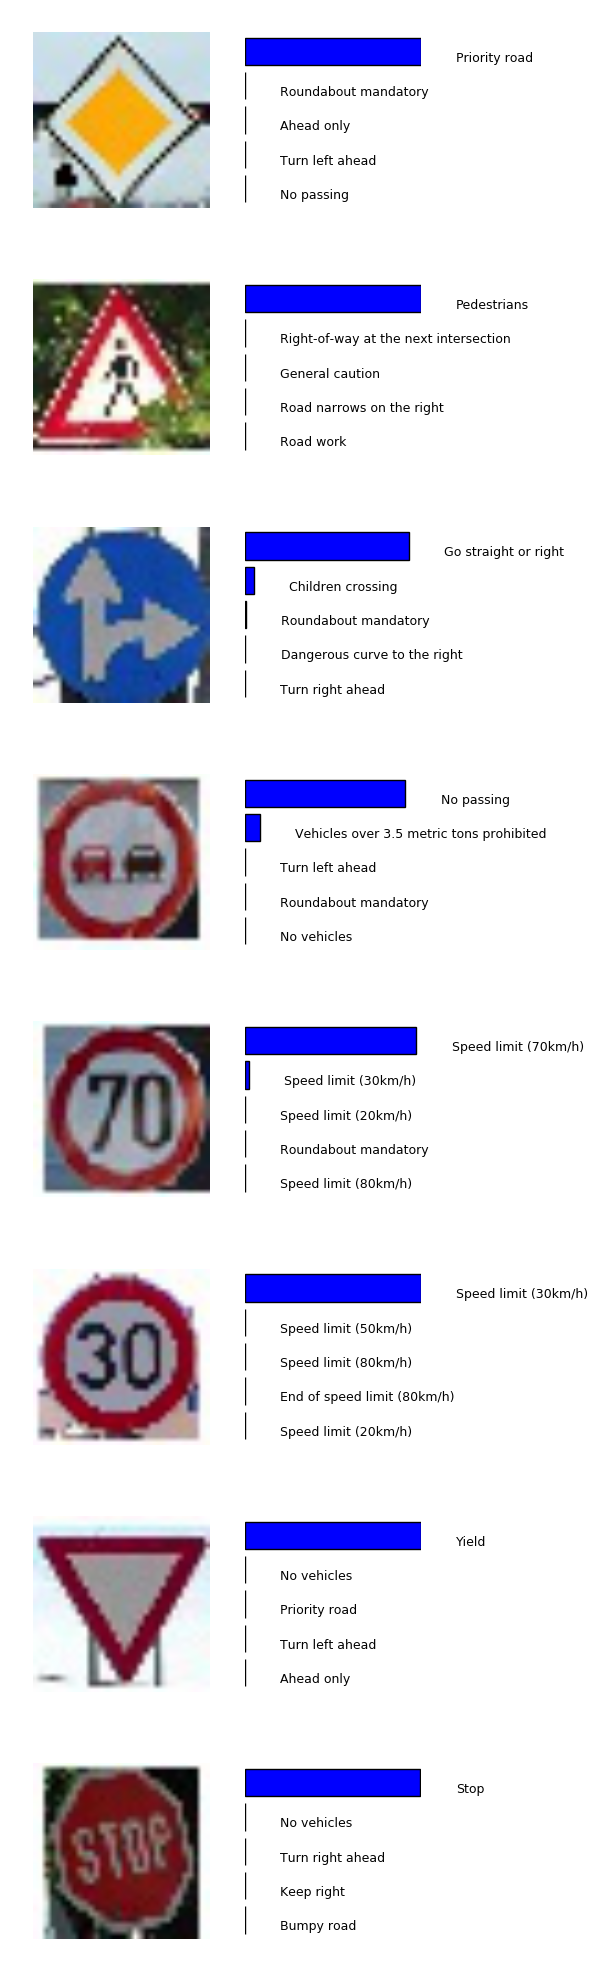

In [28]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.


### TOP 5 PROBABILITIES: CERTAINTIES

#initialize subplots
dummy, axis = plt.subplots(len(X_own_test_signs), 2, figsize=(5,25))
for i in range(len(X_own_test_signs)):
    image = X_own_test_signs[i]
    axis[i, 0].imshow(image)
    axis[i,0].axis('off')
    axis[i,1].axis('off')
    colnumber = 1
    axis[i, 1].barh(-np.arange(5),five_top_k_probabilities[1][0][i], align='center')
    
    # Print the sign names
    for x in range(5):
        axis[i, 1].text( 0.2 + five_top_k_probabilities[1][0][i][x] , (x+0.3) * -1, info_classes[five_top_k_probabilities[1][1][i][x]][3], fontsize='9')
plt.show()

# Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.